### 一. DeepWalk原理   

其实就两个阶段：   
1）对图随机游走得到一个序列；    
2）将该序列进行word2vec训练得到embedding  

下面利用对word进行embbeding训练举例，我选择了当前的一条关于新冠的新闻，对其分词构建一个带权有向图，权重为其相邻两词的出现的次数

In [1]:
#准备预料
corpus="""新华社河内5月29日电（记者蒋声雄 黄硕）越南卫生部长阮青龙29日宣布该国发现新的新冠病毒变异毒株，它是此前在英国和印度发现的变异毒株的混合体。
阮青龙当天在越南全国新冠疫情防控视频会议上说，这种变异毒株混合体“非常危险”，传播性更强，能在空气中迅速传播。这一新发现的毒株混合体尚未命名。
据“越南快报网”报道，此前在越南已发现7种新冠病毒变异毒株，包括最早在印度和英国发现的变异毒株。
越南于今年4月底出现新一轮新冠疫情，首都河内、南部胡志明市、中部岘港市等主要城市出现多个本土病例，北部北江省某工业园内发生大规模感染新冠病毒事件。据越通社报道，截至当地时间29日12时，越南累计确诊新冠本土病例5213例，其中自4月27日以来新增确诊新冠本土病例3643例"""\
.replace("\n","").replace("，","").replace("、","").replace("（","").replace("）","").replace(" ","").replace("“","").replace("”","").split("。")

In [2]:
corpus

['新华社河内5月29日电记者蒋声雄黄硕越南卫生部长阮青龙29日宣布该国发现新的新冠病毒变异毒株它是此前在英国和印度发现的变异毒株的混合体',
 '阮青龙当天在越南全国新冠疫情防控视频会议上说这种变异毒株混合体非常危险传播性更强能在空气中迅速传播',
 '这一新发现的毒株混合体尚未命名',
 '据越南快报网报道此前在越南已发现7种新冠病毒变异毒株包括最早在印度和英国发现的变异毒株',
 '越南于今年4月底出现新一轮新冠疫情首都河内南部胡志明市中部岘港市等主要城市出现多个本土病例北部北江省某工业园内发生大规模感染新冠病毒事件',
 '据越通社报道截至当地时间29日12时越南累计确诊新冠本土病例5213例其中自4月27日以来新增确诊新冠本土病例3643例']

In [3]:
import jieba
lines=[list(jieba.cut(line)) for line in corpus]#分词

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Alei\AppData\Local\Temp\jieba.cache
Loading model cost 0.619 seconds.
Prefix dict has been built successfully.


In [4]:
word_cnt={}
word_set=set()
for line in lines:
    for i in range(0,len(line)-1):
        pre_cnt=word_cnt.get((line[i],line[i+1]),0)
        word_cnt[(line[i],line[i+1])]=1+pre_cnt
        word_set.add(line[i])
        word_set.add(line[i+1])

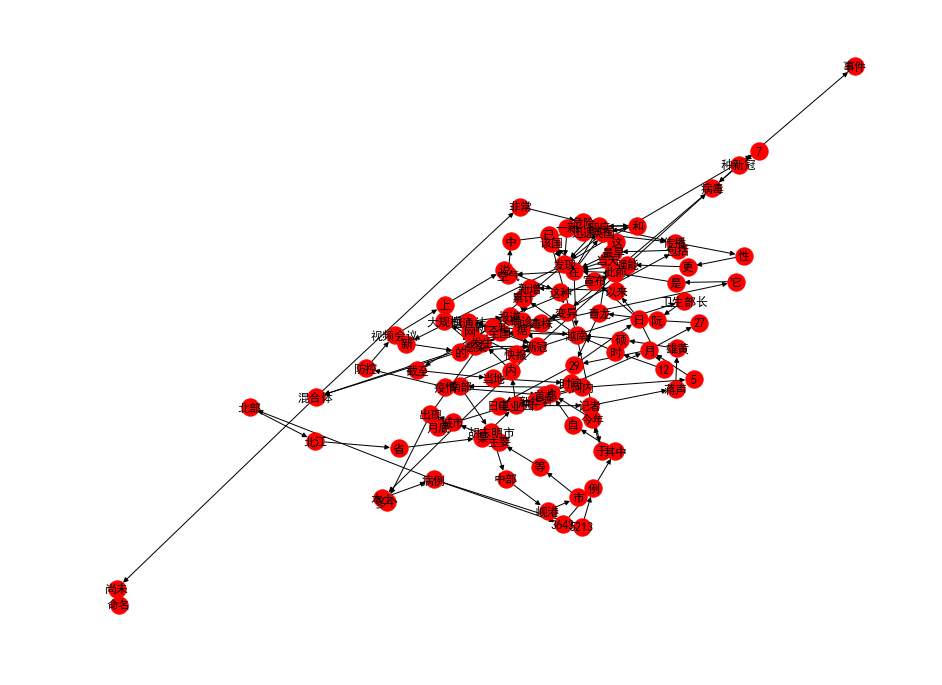

In [5]:
#构建图
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
plt.figure(figsize=(16, 12))
plt.axis("off")
G=nx.DiGraph()
G.add_edges_from([(key[0],key[1]) for key in word_cnt.keys()])
nx.draw_networkx(G)
plt.show()

### 二.随机游走实现
随机游走的核心也很简单，大概流程如下：   

1）从图中随机选择一个起始node   
2）从它的（箭头指向的）邻居中随机选择一个新node   
3）重复第2）步，直到满足终止条件，上面的所有node组成的序列即是我们所需   

另外，上面的每一步都可以自定义自己的策略，比如第1）步初始点不从图中随机选择，而是从实际句子的初始词中选择，第2）步，随机选择下一个节点时，考虑边的权值，权值越大越容易被选择，第3）步，通常可以设置一个最大游走长度

In [6]:
import numpy as np
def walk_one_time(G,start_node,walk_len):
    seq=[start_node]
    for _ in range(walk_len-1):
        current_node=seq[-1]#获取seq的最有一个节点
        next_nodes=list(G.successors(current_node))#获取所有邻居节点
        if len(next_nodes)==0:
            break
        selected_next_node=np.random.choice(next_nodes)#从所有邻居中随机选择一个
        seq.append(selected_next_node)
    return seq

In [7]:
#test
walk_one_time(G,"变异",5)

['变异', '毒株', '它', '是', '此前']

In [8]:
#将上面的过程重复多次，即可得到一个新的corpus
def deep_walk(G,walk_len=10,num_seqs=100):
    corpus=[]
    for _ in range(num_seqs):
        start_node=np.random.choice(G.nodes)
        corpus.append(walk_one_time(G,start_node,walk_len))
    return corpus

In [9]:
new_corpus=deep_walk(G)
new_corpus[0]

['包括', '最早', '在', '越南', '快报', '网', '报道', '截至', '当地', '时间']

### 三.Word2Vec的训练  

word2vec的训练可以使用gensim工具包，word2vec的原理包括两点：    

1）基于语言模型的原理，语言模型的作用用于判断一个句子出现的概率，由于句子通常会被分词，所有语言模型可以看作判断一个词语序列的出现概率，好的语言模型应该能做到比如如下的判断：   

$$
Proba([[变异],[毒株],[混合体],[非常],[危险]])>Proba([[变异],[危险],[混合体],[非常],[毒株]])
$$  

显然，第一句是人话，第二句读不通  

2）而word2vec就是利用极大似然估计的方式让我们的人话出现的概率尽可能高，而鬼话的概率尽可能小，它采用三层的网络结构，  
>2.1）第一层是input层，它与我们的词典一一对应   

>2.2）中间层是hidden层，它就是我们embedding的维度    

>2.3）最后一层是output层，它同样与我们的词典一一对应  

它的训练如下图，  

>1）我们对输入的文本截取一定的窗口，比如window_size=2，那么我们选取目标次前后的2X2+1=5个词语，比如[[变异],[毒株],[混合体],[非常],[危险]]这5个词语  

>2）然后，我们构建([变异],[毒株],[非常],[危险])->([混合体])的映射，其中前半部分，我们称作[混合体]的上下文   

>3）最后，我们利用极大似然估计估计上面的上下文和目标词的映射概率尽可能的大

![avatar](./pic/cbow.jpg)

In [10]:
from gensim.models import word2vec
model = word2vec.Word2Vec(new_corpus,window=2,vector_size=5,min_count=1)

In [11]:
#查看embedding
model.wv["变异"]

array([-0.19377613,  0.10809163, -0.16566691, -0.09616406,  0.00191299],
      dtype=float32)

In [12]:
model.wv["混合体"]

array([ 0.15368475, -0.18145339,  0.00444265,  0.05817473, -0.01261494],
      dtype=float32)

这样，我们就为图上的每个节点训练出了一个embedding，另外上面的训练过程实际是采用了CBOW的方式，即用上下文来预测某个词，而实际deepwalk更多是使用**skip-gram**的方式，即利用单个词去预测它的上下文（上面图中的箭头反向），这样训练的embedding效果通常会更好